## Introduction

Now you have learnt how to make $N$-body simulations, we can start to find DM halos from the particles. And the most commonly used method for this is called the friends-of-friends (fof) algorithm. The idea is quite simple: if a DM particle $A$ is close enough to any other particles belong to a DM halo $B$, then particle $A$ belongs to halo $B$. You can read more about the friends of friends algorithm at e.g. here: https://swift.dur.ac.uk/docs/FriendsOfFriends/algorithm_description.html

### Goals:
* Run a friends of friends algorithm on a simulation
* Plot particles that are in haloes
* Plot a halo mass function
* Plot displacement fields in Lagrangian space
* Plot halo particles in Lagrangian space

In [ ]:
### Run the following lines in your terminal to install the pyfof package
# git clone https://github.com/simongibbons/pyfof
# cd pyfof/
# pip install --use-pep517 .

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../../../")

import sheet_unfolding.sim as sim
from matplotlib.colors import LogNorm

import pyfof 

## Run a simulation

First, we need to get the particle distribution by running a simulation. The code you have worked on in the last notebook is implemented in `sim.CosmologicalSimulation2d` so we don't need to write it here again.

In [2]:
myic = sim.ic.IC2DCosmo(512, L=100., rs=1.5, sigma8=2.)

mysim = sim.CosmologicalSimulation2d(myic, aic=0.02, dafac_max=0.05, da_max=0.02, ngrid_pm=128)

mysim.integrate_till(1.)

integrate time 2.0000e-02 -> 1.0000e+00  with da=0.001  (980 steps)


Text(0, 0.5, '$y$ [Mpc/$h$]')

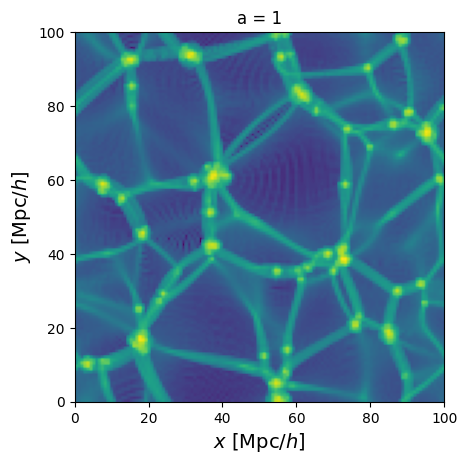

In [3]:
rho = sim.sim.deposit2d(mysim.pos, 128, myic.L, mode="cic")
plt.imshow(np.clip(rho / np.mean(rho), 1e-2, None).T, origin="lower", norm = LogNorm(vmin=1e-2, vmax=1e2), extent=[0,100.,0.,100.])
plt.title("a = %g" % mysim.a)
plt.xlabel(r"$x$ [Mpc/$h$]", fontsize=14)
plt.ylabel(r"$y$ [Mpc/$h$]", fontsize=14)

## Find halos with fof

Now we need to find friends of friends groups with a linking length of 0.2 mean particle separations. Discard all groups which have less than 20 members. Then **make a density plot of particles that are in a group with N>=20 members, and compare it with the density plot of all particles.**

Note: What we are doing here is not exactly correct, because we are neglecting the periodic boundary conditions. However, let's keep it simple for now ;)

In [4]:
linking_length = 0.2*np.sqrt(np.mean(100.**2/512.**2))
print(linking_length)

0.0390625


In [16]:
import importlib.util

spec = importlib.util.find_spec("pyfof")
print(spec.origin)

/Users/hong-gangyang/anaconda3/envs/marcos_test/lib/python3.11/site-packages/pyfof.cpython-311-darwin.so


In [5]:
res = pyfof.friends_of_friends(mysim.pos.reshape(-1,2), linking_length)

/var/folders/zw/60xz9kgx1pq6wsz9pv89s8cc0000gn/T/ipykernel_4030/3162636916.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  res = pyfof.friends_of_friends(mysim.pos.reshape(-1,2), linking_length)


In [9]:
allids = []
for igroup,inds_in_group in enumerate(res):
    if len(inds_in_group) >= 20:
        allids += inds_in_group
allids = np.array(allids)

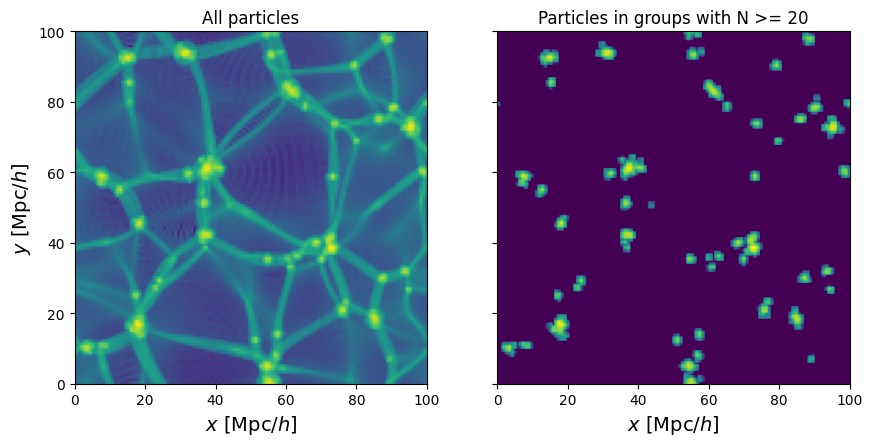

In [10]:
rho1 = sim.sim.deposit2d(mysim.pos, 128, myic.L, mode="cic")
rho2 = sim.sim.deposit2d(mysim.pos.reshape(-1,2)[allids], 128, myic.L, mode="cic")

fig, axs = plt.subplots(1,2, figsize=(10,5),sharey=True)
axs[0].imshow(np.clip(rho1 / np.mean(rho1), 1e-2, None).T, origin="lower", norm = LogNorm(vmin=1e-2, vmax=1e2), extent=[0,100.,0.,100.])
axs[1].imshow(np.clip(rho2 / np.mean(rho1), 1e-2, None).T, origin="lower", norm = LogNorm(vmin=1e-2, vmax=1e2), extent=[0,100.,0.,100.])
axs[0].set_title("All particles")
axs[1].set_title("Particles in groups with N >= 20");
for ax in axs:
    ax.set_xlabel(r"$x$ [Mpc/$h$]", fontsize=14)
axs[0].set_ylabel(r"$y$ [Mpc/$h$]", fontsize=14)

plt.savefig("img/haloes_versus_particles.png", bbox_inches="tight")

# Plot the halo mass function

Plot the fof halo mass function. I.e. the number of objects with a given mass (through a histogram). The mass of a fof-group equals the sum of the masses of the particles in the group. Since all particles have equal mass, you can just multiply the length of the group by the particle mass $m_0$.

In [11]:
m0 = mysim.mass[0,0]
print(m0) # in the unit of M_sun

10587690962.236044


In [12]:
lens = []
ifof = np.zeros(mysim.pos.shape[0:2], dtype=np.int64)
for igroup,inds_in_group in enumerate(res):
    if len(inds_in_group) > 20:
        lens.append(len(inds_in_group))

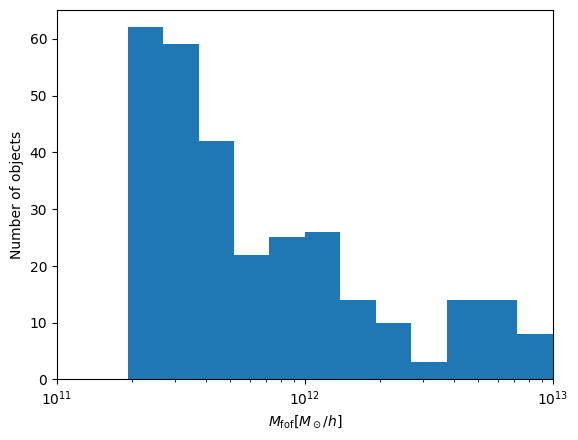

In [13]:
bins = np.logspace(11,13,15)
plt.hist(np.array(lens)*m0, bins=bins)
plt.xscale("log")
plt.xlabel(r"$M_{\rm{fof}} [M_\odot / h]$")
plt.ylabel("Number of objects")
plt.xlim(1e11, 1e13)
plt.savefig("img/haloes_massfunction.png")

## Lagrangian space

Now that you know how to run a simulation, let's explore a bit about seeing the simulation results from a new perspective -- in the Lagrangian space! 

Lagrangian space is basically the space of the initial locations of particles. We started with all particles on a grid (myic.qi[...,0:2]). Since we kept all particles in the same order (i.e. if the initial location of particle $A$ is stored at `myic.qi[i,j]`, then its final location is stored in `mysim.pos[i,j]`), making a Lagrangian plot can be as simple as an plt.imshow(myparticleproperty, ...)

Let's plot the displacement field in Lagrangian space. The displacement field  $\vec{s}$ describes how much a particle moved from its initial location and it is defined so that
\begin{align}
\vec{x}(\vec{q}) = \vec{q} + \vec{s}(\vec{q})
\end{align}

where $\vec{x}$ are the particle positions and $\vec{q}$ their Lagrangian (initial coordinates). Therefore in principle $\vec{s} = \vec{x} - \vec{q}$. However, since we always wrap particle positions periodically between $[0,L]$, you have to undo the periodic wrapping. You can do this by subtracting/adding $L$ so that $\vec{s}$ lies in $[-L/2, L/2]$.

Make a plot of each, the x and y components, of the $\vec{s}$. Further, put a quiver plot on top to indicate the displacement by arrows (To avoid overcrowding the image, in the quiver plot only show the displacement for every 16th particle).

In [14]:
L = 100.
disp = (((mysim.pos - myic.qi) + L/2.) % L) - L/2.

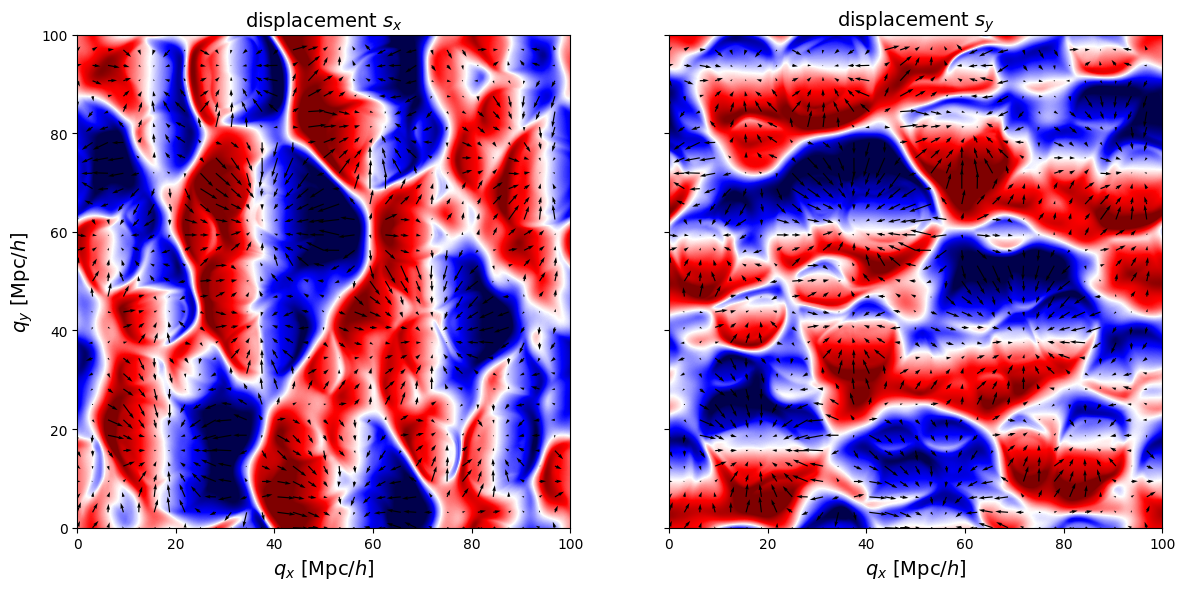

In [15]:
fig, axs = plt.subplots(1,2, figsize=(14,8), sharey=True)

axs[0].imshow(disp[...,0].T, origin="lower", extent=[0,100.,0.,100.],cmap="seismic",vmin=-10.,vmax=10.)
axs[1].imshow(disp[...,1].T, origin="lower", extent=[0,100.,0.,100.],cmap="seismic",vmin=-10.,vmax=10.)
for ax in axs:
    ax.quiver(myic.qi[::16,::16,0], myic.qi[::16,::16,1], disp[::16,::16,0], disp[::16,::16,1], color="black")
    ax.set_xlabel(r"$q_x$ [Mpc/$h$]", fontsize=14)
axs[0].set_ylabel(r"$q_y$ [Mpc/$h$]", fontsize=14)

axs[0].set_title(r"displacement $s_x$", fontsize=14)
axs[1].set_title(r"displacement $s_y$", fontsize=14)
plt.savefig("img/haloes_lagrangian_displacement.png")

## Lagrangian space haloes

You have seen the DM haloes in Euclidean space, now let's have a look at the Lagrangian space haloes, which basically gives you the info about which group of particles at the initial condition ends up being in the same haloes. 

### Task
Plot the halo index in Lagrangian space, so that different haloes will have different colors. Also plot the displacement field on top as a quiver plot. To get the halo index in Lagrangian space, you will have to mark each particle by the halo index it is part of. For this you will have to rearange a bit the information that you got from the output of pyfof.

In [16]:
ifof = np.zeros(mysim.pos.shape[0:2], dtype=np.int64)
for igroup,inds_in_group in enumerate(res):
    if len(inds_in_group) > 20:
        ifof.flat[inds_in_group] = igroup

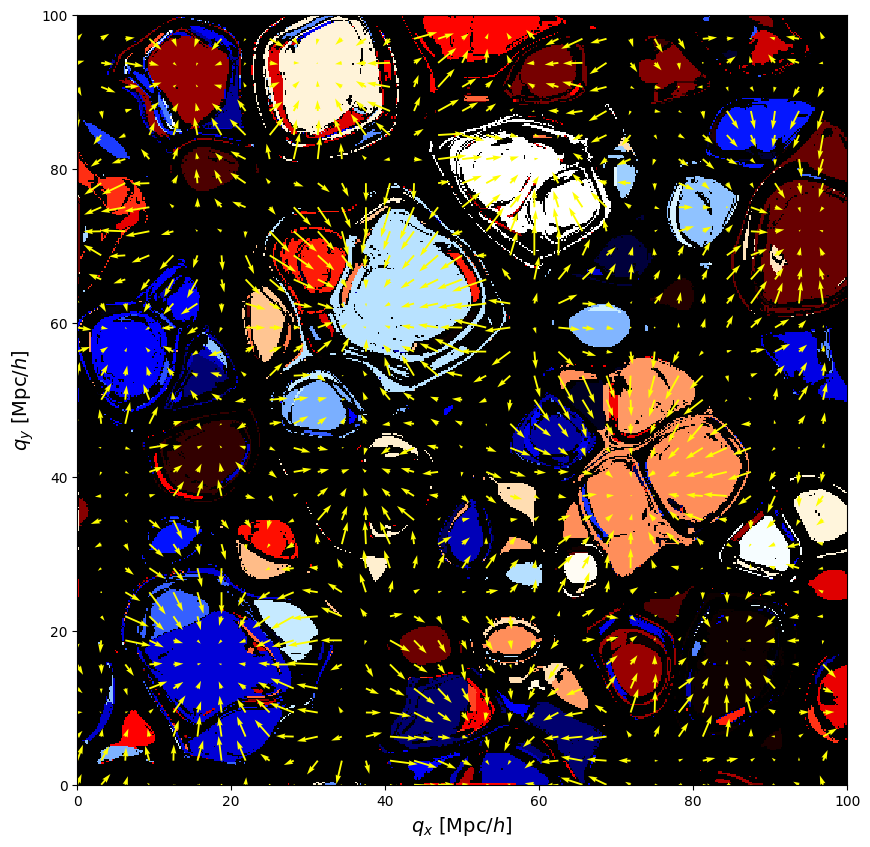

In [17]:
plt.figure(figsize=(10,10))
ax = plt.gca()
ax.imshow(ifof.T, origin="lower", extent=[0,100.,0.,100.], cmap="flag_r", interpolation="none")
ax.quiver(myic.qi[::16,::16,0], myic.qi[::16,::16,1], disp[::16,::16,0], disp[::16,::16,1], color="yellow")

ax.set_xlabel(r"$q_x$ [Mpc/$h$]", fontsize=14)
ax.set_ylabel(r"$q_y$ [Mpc/$h$]", fontsize=14)
plt.savefig("img/haloes_lagrangian_protohaloes.png")